In [ ]:
# This is a notebook to test the stage calibration. It is based on the example script testStageCalibration.py. The notebook is used to test the stage calibration and to visualize the results.

In [1]:
#%%
import imswitchclient.ImSwitchClient as imc 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from skimage.registration import phase_cross_correlation

stageName=None
scanMax=100
scanMin=-100
scanStep = 50
rescalingFac=10.0
gridScan=True
pixelSize = 1.0
isHTTPS = False
mPort = 8001

# Instantiate the ImSwitchClient
client = imc.ImSwitchClient(host="localhost", isHttps=isHTTPS, port=mPort) 


In [8]:
laser_names = client.lasersManager.getLaserNames()
print(laser_names)
mLaserName = laser_names[0]
client.lasersManager.setLaserActive(mLaserName, True)
client.lasersManager.setLaserValue(mLaserName, 1023)

['LED']


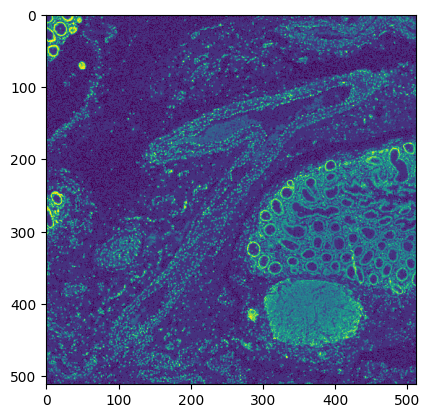

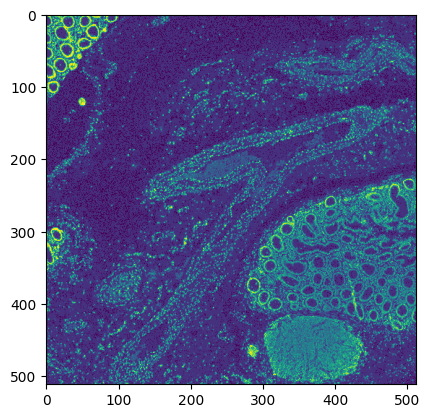

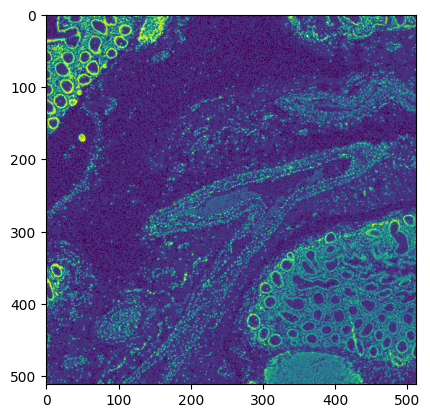

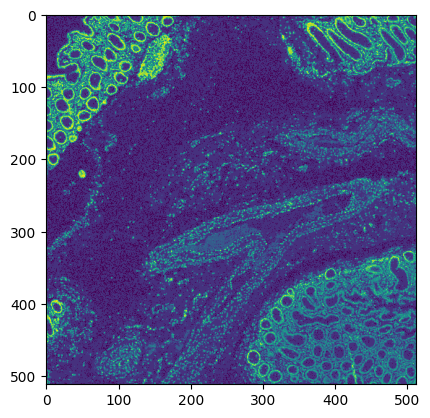

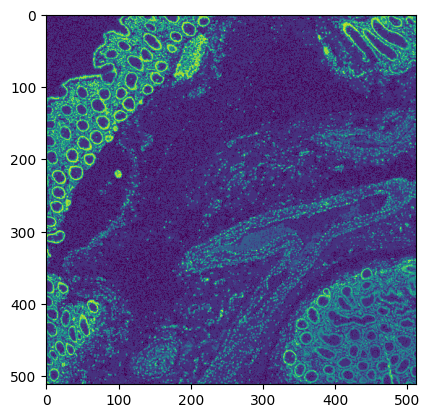

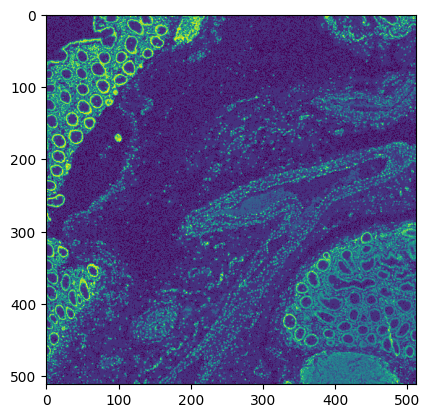

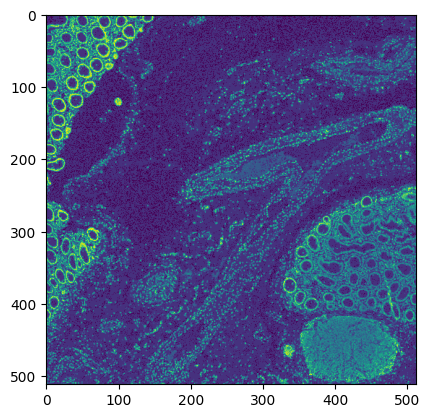

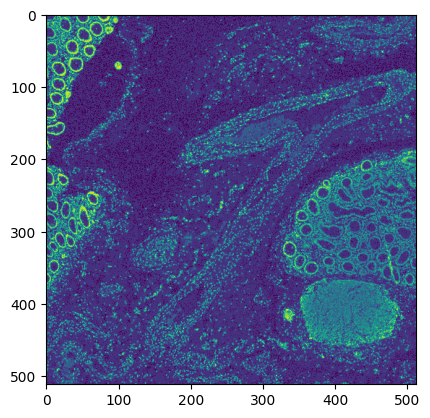

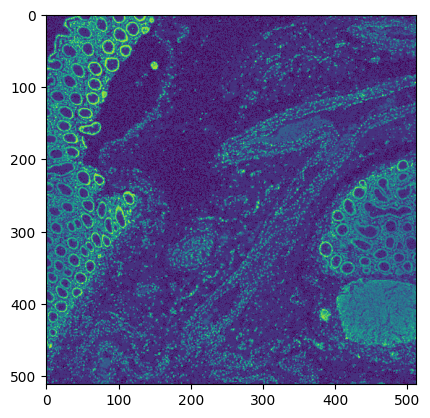

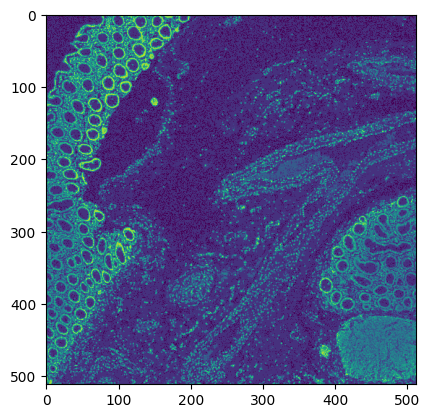

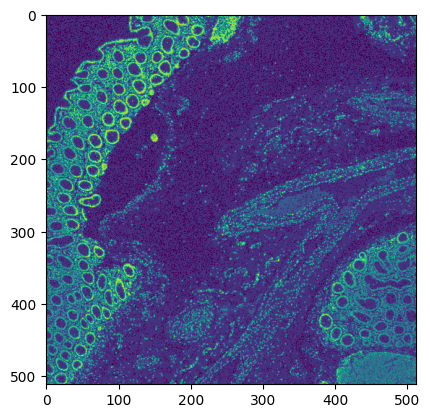

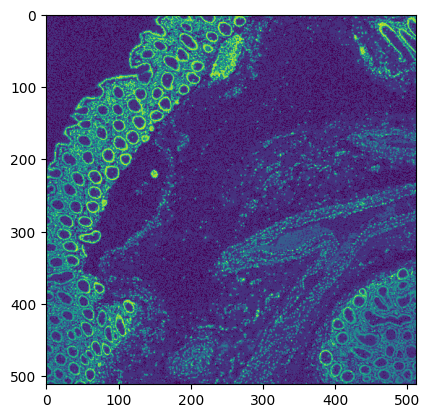

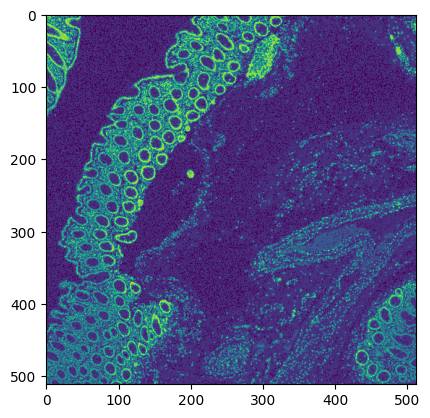

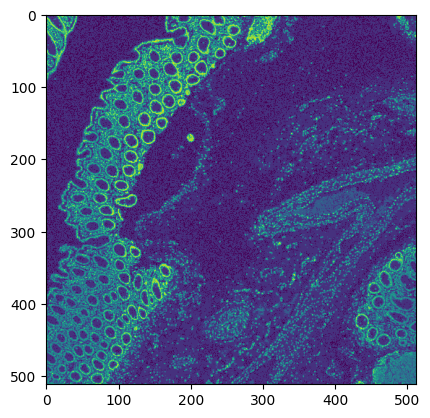

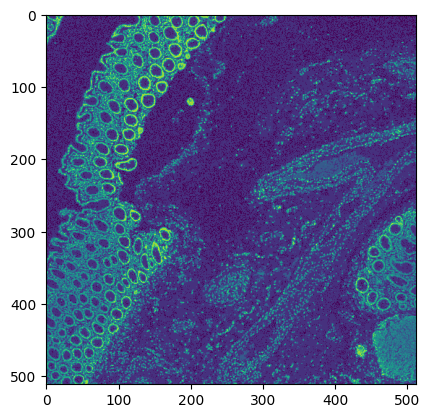

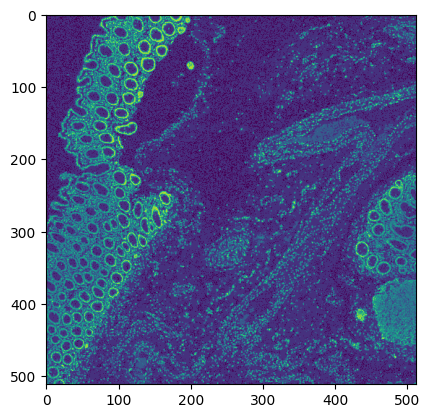

In [9]:
#%%
# Test the get_positioner_names method
positioner_names = client.positionersManager.getAllDeviceNames()
positioner_name = positioner_names[0]

currentPositions = client.positionersManager.getPositionerPositions()[positioner_name]
initialPosition = (currentPositions["X"], currentPositions["Y"])
initialPosiionZ = currentPositions["Z"]

scanMin = -100
scanMax = 100
scanStep = 50

# snake scan
if gridScan:
    xyScanStepsAbsolute = []
    fwdpath = np.arange(scanMin, scanMax, scanStep)
    bwdpath = np.flip(fwdpath)
    for indexX, ix in enumerate(np.arange(scanMin, scanMax, scanStep)): 
        if indexX%2==0:
            for indexY, iy in enumerate(fwdpath):
                xyScanStepsAbsolute.append([ix, iy])
        else:
            for indexY, iy in enumerate(bwdpath):
                xyScanStepsAbsolute.append([ix, iy])
    xyScanStepsAbsolute = np.array(xyScanStepsAbsolute)    
else:
    # avoid grid pattern to be detected as same locations => random positions
    xyScanStepsAbsolute = np.random.randint(scanMin, scanMax, (10,2))

#%%
# initialize xy coordinates
value = xyScanStepsAbsolute[0,0] + initialPosition[0], xyScanStepsAbsolute[0,1] + initialPosition[1]
client.positionersManager.movePositioner(positioner_name, "X", value[0], is_absolute=True, is_blocking=True)
client.positionersManager.movePositioner(positioner_name, "Y", value[1], is_absolute=True, is_blocking=True)

# store images
allPosImages = []
for ipos, iXYPos in enumerate(xyScanStepsAbsolute):
    
    # move to xy position is necessary
    value = iXYPos[0]+initialPosition[0],iXYPos[1]+initialPosition[1]
    client.positionersManager.movePositioner(positioner_name, "X", value[0], is_absolute=True, is_blocking=True)
    client.positionersManager.movePositioner(positioner_name, "Y", value[1], is_absolute=True, is_blocking=True)

    #TODO: do we move to the correct positions?
    # antishake
    time.sleep(0.5)
    lastFrame = client.recordingManager.snapNumpyToFastAPI()
    allPosImages.append(lastFrame)
    plt.imshow(lastFrame), plt.show()

# reinitialize xy coordinates
value = initialPosition[0], initialPosition[1]
client.positionersManager.movePositioner(positioner_name, "X", value[0], is_absolute=True, is_blocking=True)
client.positionersManager.movePositioner(positioner_name, "Y", value[1], is_absolute=True, is_blocking=True)


In [5]:

# process the slices and compute their relative distances in pixels
# compute shift between images relative to zeroth image
print("Starting to compute relative displacements from the first image")
allShiftsComputed = []
for iImage in range(len(allPosImages)):
    image1 = allPosImages[0] 
    image2 = allPosImages[iImage]
    
    if len(image1.shape)>2:
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    # downscaling will reduce accuracy, but will speed up computation
    image1 = cv2.resize(image1, dsize=None, dst=None, fx=1/rescalingFac, fy=1/rescalingFac)
    image2 = cv2.resize(image2, dsize=None, dst=None, fx=1/rescalingFac, fy=1/rescalingFac)

    shift, error, diffphase = phase_cross_correlation(image1, image2)
    shift *=rescalingFac
    print("Shift w.r.t. 0 is:"+str(shift))
    allShiftsComputed.append((shift[0],shift[1]))
    
# compute averrage shifts according to scan grid 
# compare measured shift with shift given by the array of random coordinats
allShiftsPlanned = np.array(xyScanStepsAbsolute)
allShiftsPlanned -= np.min(allShiftsPlanned,0)
allShiftsComputed = np.array(allShiftsComputed)

# compute differencs
nShift = (scanMax-scanMin)//scanStep





Starting to compute relative displacements from the first image
Shift w.r.t. 0 is:[0. 0.]
Shift w.r.t. 0 is:[ 210. -130.]
Shift w.r.t. 0 is:[ 80. 200.]
Shift w.r.t. 0 is:[ -20. -210.]
Shift w.r.t. 0 is:[ 200. -210.]
Shift w.r.t. 0 is:[ 140. -130.]
Shift w.r.t. 0 is:[-20. 200.]
Shift w.r.t. 0 is:[240. 150.]
Shift w.r.t. 0 is:[ 50. -40.]
Shift w.r.t. 0 is:[-220. -130.]
Shift w.r.t. 0 is:[210. -50.]
Shift w.r.t. 0 is:[100.  80.]
Shift w.r.t. 0 is:[230. 130.]
Shift w.r.t. 0 is:[240. -90.]
Shift w.r.t. 0 is:[-70. 120.]
Shift w.r.t. 0 is:[-50.  60.]


ValueError: axes don't match array

In [8]:

# determine the axis and swap if necessary (e.g. swap axis (y,x))
dReal = np.abs(allShiftsPlanned-np.roll(allShiftsPlanned,-1,0))
dMeasured = np.abs(allShiftsComputed-np.roll(allShiftsComputed,-1,0))
xAxisReal = np.argmin(np.mean(dReal,0))
xAxisMeasured = np.argmin(np.mean(dMeasured,0))
if xAxisReal != xAxisMeasured:
    xAxisMeasured = np.transpose(xAxisMeasured, (1,0))

# stepsize => real motion / stepsize 
stepSizeStage = (dMeasured*pixelSize)/dReal
stepSizeStage[stepSizeStage == np.inf] = 0
stepSizeStage = np.nan_to_num(stepSizeStage, nan=0.)
stepSizeStage = stepSizeStage[np.where(stepSizeStage>0)]
stepSizeStageDim = np.mean(stepSizeStage)
stepSizeStageVar = np.var(stepSizeStage)




array([[  0,   0],
       [  0,  50],
       [  0, 100],
       [  0, 150],
       [ 50, 150],
       [ 50, 100],
       [ 50,  50],
       [ 50,   0],
       [100,   0],
       [100,  50],
       [100, 100],
       [100, 150],
       [150, 150],
       [150, 100],
       [150,  50],
       [150,   0]])

In [15]:
dMeasured

array([[210., 130.],
       [130., 330.],
       [100., 410.],
       [220.,   0.],
       [ 60.,  80.],
       [160., 330.],
       [260.,  50.],
       [190., 190.],
       [270.,  90.],
       [430.,  80.],
       [110., 130.],
       [130.,  50.],
       [ 10., 220.],
       [310., 210.],
       [ 20.,  60.],
       [ 50.,  60.]])

(0.0, 0.0)


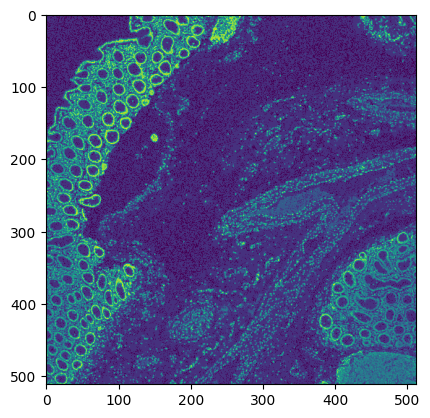

0.7971818447113037
(0.0, 200.0)


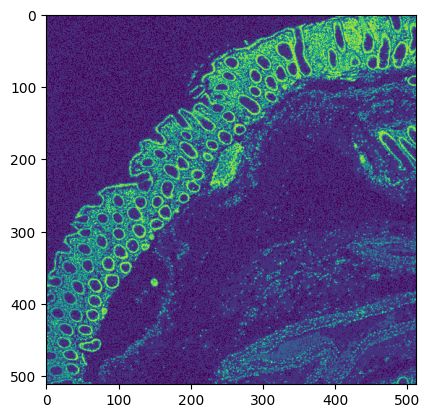

0.4429137706756592
(0.0, 0.0)


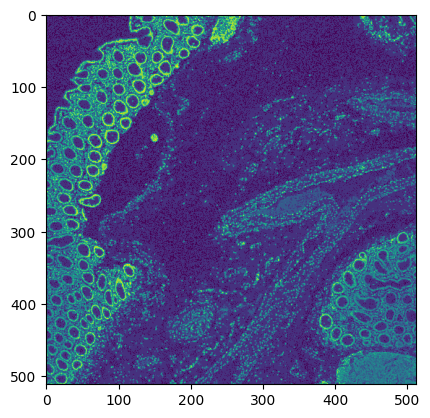

0.4289281368255615
(100.0, 0.0)


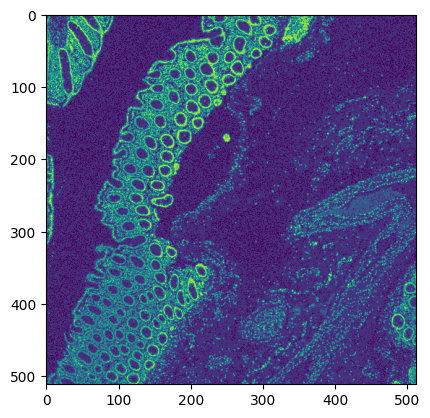

0.4314899444580078
(0.0, 0.0)


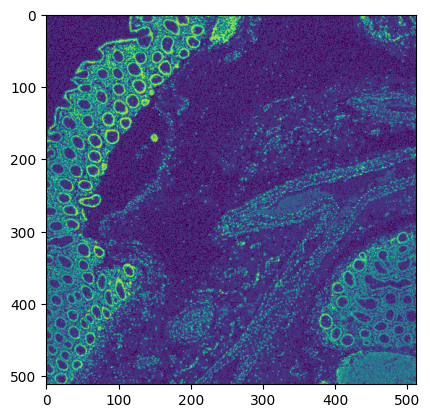

0.4213738441467285


In [18]:
# Retrieve the first positioner's name and current position
positioner_names = client.positionersManager.getAllDeviceNames()
positioner_name = positioner_names[0]
currentPositions = client.positionersManager.getPositionerPositions()[positioner_name]
initialPosition = (currentPositions["X"], currentPositions["Y"])

# turn on illumination
mLaserName = client.lasersManager.getLaserNames()[0]
client.lasersManager.setLaserActive(mLaserName, True)
client.lasersManager.setLaserValue(mLaserName, 1023)

positionList = [(0,0), 
                (0,200),
                (0,0), 
                (100,0),
                (0,0)]

                
mStack = []
mPositions = []
#for ix in range(10):
#    for iy in range(10):
for iIndex, iPosition in enumerate(positionList):
        mTime = time.time()
        # Define and move to a new position
        newPosition = (initialPosition[0] + iPosition[0], initialPosition[1] + iPosition[1])
        print(newPosition)
        # client.positionersManager.movePositioner(positioner_name, "XY", [newPosition[0], newPosition[1]], is_absolute=True, is_blocking=True)  
        client.positionersManager.movePositioner(positioner_name, "X", newPosition[0], is_absolute=True, is_blocking=True)  
        time.sleep(0.1)
        client.positionersManager.movePositioner(positioner_name, "Y", newPosition[1], is_absolute=True, is_blocking=True)  
        
        # Acquire and display an image
        #time.sleep(2)  # Allow time for the move
        lastFrame = client.recordingManager.snapNumpyToFastAPI()
        mStack.append(lastFrame)
        currentPositions = client.positionersManager.getPositionerPositions()[positioner_name]
        currentPositionsXY = (currentPositions["X"], currentPositions["Y"])
        mPositions.append(currentPositionsXY)
        if 1:
            plt.imshow(lastFrame)
            plt.show()
        print(time.time()-mTime)
# Return the positioner to its initial position
client.positionersManager.movePositioner(positioner_name, "X", initialPosition[0], is_absolute=True, is_blocking=True)
client.positionersManager.movePositioner(positioner_name, "Y", initialPosition[1], is_absolute=True, is_blocking=True)


[0. 0.]
[200.   0.]
[0. 0.]
[  0. 100.]
[0. 0.]
known shift: [(0, 0, 0), (0, 200, 0), (0, 0, 0), (100, 0, 0), (0, 0, 0)]
computed shift: [(0.0, 0.0), (0.0, 200.0), (0.0, 0.0), (100.0, 0.0), (0.0, 0.0)]


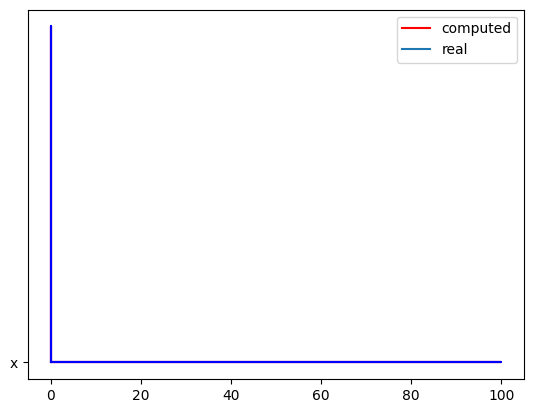

In [13]:
# we assume we have a structured sample in focus
# the sample is moved around and the deltas are measured
# everything has to be inside a thread
# process the slices and compute their relative distances in pixels
# compute shift between images relative to zeroth image
allShiftsComputed = []
rescalingFac = 1 # in case the images are too big we should scale them down! 
for iImage in range(len(mStack)):
    image1 = mStack[0]# cv2.cvtColor(mStack[0], cv2.COLOR_BGR2GRAY)
    image2 = mStack[iImage] #cv2.cvtColor(mStack[iImage], cv2.COLOR_BGR2GRAY)
    
    # downscaling will reduce accuracy, but will speed up computation
    image1 = cv2.resize(image1, dsize=None, dst=None, fx=1/rescalingFac, fy=1/rescalingFac)
    image2 = cv2.resize(image2, dsize=None, dst=None, fx=1/rescalingFac, fy=1/rescalingFac)

    # produces coordinates that can be used to align two imags with the shift function, axis = y,x and image2 on image1
    shift, error, diffphase = phase_cross_correlation(image2, image1)
    print(shift)
    shift *=rescalingFac
    allShiftsComputed.append((shift[1],shift[0]))

import matplotlib.pyplot as plt 
# computed positions
x, y = np.array(allShiftsComputed).T
plt.plot(x,y, 'r', 'x')
# positions sent to the microscope
xm, ym, z = np.array(positionList).T
plt.plot(xm,ym, 'b', 'x')
plt.legend(("computed", "real"))
print("known shift: "+str(positionList))
print("computed shift: "+str(allShiftsComputed))
plt.show()



In [35]:
# now we need to find the match and eventually correct for it 
directions_computed = (np.array(allShiftsComputed)/np.array(positionList))
directions_computed[np.isnan(directions_computed)] = 0
directions_computed = (directions_computed != 0)*1
directions_expected = (np.array(positionList)>1)*1
# compare the directions
print(directions_computed-directions_expected)

# differentiate between flipping dimensions 


[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]


/var/folders/4w/k4yhf14j7xsbp2jd85yk555r0000gn/T/ipykernel_29318/818184893.py:2: RuntimeWarning: invalid value encountered in divide
  directions_computed = (np.array(allShiftsComputed)/np.array(positionList))


In [ ]:
# now we need to find the match and eventually correct for it 
directions_computed = (np.array(allShiftsComputed)/np.array(positionList))
directions_computed[np.isnan(directions_computed)] = 0
directions_computed = (directions_computed != 0)*1
directions_expected = (np.array(positionList)>1)*1
# compare the directions
print(directions_computed-directions_expected)

# differentiate between flipping dimensions 


[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]


/var/folders/4w/k4yhf14j7xsbp2jd85yk555r0000gn/T/ipykernel_29318/818184893.py:2: RuntimeWarning: invalid value encountered in divide
  directions_computed = (np.array(allShiftsComputed)/np.array(positionList))


In [36]:
!pip install -e . /Users/bene/Dropbox/Dokumente/Promotion/PROJECTS/MicronController/PYTHON/camera-stage-mapping
from camera_stage_mapping.camera_stage_calibration_1d import calibrate_backlash_1d, image_to_stage_displacement_from_1d
from camera_stage_mapping.camera_stage_tracker import Tracker
from camera_stage_mapping.closed_loop_move import closed_loop_move, closed_loop_scan
from camera_stage_mapping.scan_coords_times import ordered_spiral

Processing /Users/bene/Dropbox/Dokumente/Promotion/PROJECTS/MicronController/PYTHON/camera-stage-mapping
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [11 lines of output]
      Could not fetch URL https://pypi.org/simple/poetry/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/poetry/ (Caused by SSLError("Can't connect to HTTPS URL because the SSL module is not available.")) - skipping
      ERROR: Could not find a version that satisfies the requirement poetry>=0.12 (from versions: none)
      ERROR: No matching distribution found for poetry>=0.12
      Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError

In [ ]:
class CSMExtension(object):
    """
    Use the camera as an encoder, so we can relate camera and stage coordinates
    """

    def __init__(self, client):
        self._client = client


    def update_settings(self, settings):
        """Update the stored extension settings dictionary"""
        if 0:
            pass
            '''
            keys = ["extensions", self.name]
            dictionary = create_from_path(keys)
            set_by_path(dictionary, keys, settings)
            logging.info(f"Updating settings with {dictionary}")
            self.microscope.update_settings(dictionary)
            self.microscope.save_settings()
            '''

    def get_settings(self):
        """Retrieve the settings for this extension"""
        if 0:
            keys = ["extensions", self.name]
            #return get_by_path(self.microscope.read_settings(), keys)
        return {}

    def camera_stage_functions(self):
        """Return functions that allow us to interface with the microscope"""
        
        def grabCroppedFrame(crop_size=512):
            marray = self._client.detector.getLatestFrame()
            center_x, center_y = marray.shape[1] // 2, marray.shape[0] // 2

            # Calculate the starting and ending indices for cropping
            x_start = center_x - crop_size // 2
            x_end = x_start + crop_size
            y_start = center_y - crop_size // 2
            y_end = y_start + crop_size

            # Crop the center region
            return marray[y_start:y_end, x_start:x_end]

        def getPositionList():
            posDict = self._client.positionersManager[self._client.positionersManager.getAllDeviceNames()[0]].getPosition()
            return (posDict["X"], posDict["Y"], posDict["Z"])

        def movePosition(posList):
            stage = self._client.positionersManager[self._client.positionersManager.getAllDeviceNames()[0]]
            stepSizeX = 1
            stepSizeY = 1
            stage.move(value=posList[0]/stepSizeX, axis="X", is_absolute=True, is_blocking=True)
            stage.move(value=posList[1]/stepSizeY, axis="Y", is_absolute=True, is_blocking=True)
            self._parent._logger.info("Moving to: "+str(posList))
            if len(posList)>2:
                stage.move(value=posList[2], axis="Z", is_absolute=True, is_blocking=True)

        grab_image = grabCroppedFrame
        get_position = getPositionList
        move = movePosition
        wait = time.sleep(0.1)

        return grab_image, get_position, move, wait

    def calibrate_1d(self, direction):
        """Move a microscope's stage in 1D, and figure out the relationship with the camera"""
        grab_image, get_position, move, wait = self.camera_stage_functions()
        move = LoggingMoveWrapper(move)  # log positions and times for stage calibration

        tracker = Tracker(grab_image, get_position, settle=wait)

        result = calibrate_backlash_1d(tracker, move, direction)
        result["move_history"] = move.history
        return result
    


    def calibrate_xy(self):
        """Move the microscope's stage in X and Y, to calibrate its relationship to the camera"""
        self._parent._logger.info("Calibrating X axis:")
        cal_x = self.calibrate_1d(np.array([1, 0, 0]))
        self._parent._logger.info("Calibrating Y axis:")
        cal_y = self.calibrate_1d(np.array([0, 1, 0]))

        # Combine X and Y calibrations to make a 2D calibration
        cal_xy = image_to_stage_displacement_from_1d([cal_x, cal_y])
        self.update_settings(cal_xy)

        data = {
            "camera_stage_mapping_calibration": cal_xy,
            "linear_calibration_x": cal_x,
            "linear_calibration_y": cal_y,
        }
        CSM_DATAFILE_PATH = os.path.join(dirtools.UserFileDirs.Root, "pixelcalibration_uc2.json")

        # Custom JSON encoder for NumPy arrays
        class NumpyEncoder(json.JSONEncoder):
            def default(self, obj):
                if isinstance(obj, np.ndarray):
                    return obj.tolist()  # Convert NumPy arrays to lists
                return super(NumpyEncoder, self).default(obj)

        # Convert NumPy arrays to lists and save the JSON file with the custom encoder
        with open(CSM_DATAFILE_PATH, 'w') as json_file:
            json.dump(data, json_file, indent=4, sort_keys=True, cls=NumpyEncoder)
        return data

    @property
    def image_to_stage_displacement_matrix(self):
        """A 2x2 matrix that converts displacement in image coordinates to stage coordinates."""
        try:
            settings = self.get_settings()
            return settings["image_to_stage_displacement"]
        except KeyError:
            raise ValueError("The microscope has not yet been calibrated.")

    def move_in_image_coordinates(self, displacement_in_pixels):
        """Move by a given number of pixels on the camera"""
        p = np.array(displacement_in_pixels)
        relative_move = np.dot(p, self.image_to_stage_displacement_matrix)
        self.microscope.stage.move_rel([relative_move[0], relative_move[1], 0])

    def closed_loop_move_in_image_coordinates(self, displacement_in_pixels, **kwargs):
        """Move by a given number of pixels on the camera, using the camera as an encoder."""
        grab_image, get_position, move, wait = self.camera_stage_functions()

        tracker = Tracker(grab_image, get_position, settle=wait)
        tracker.acquire_template()
        closed_loop_move(tracker, self.move_in_image_coordinates, displacement_in_pixels, **kwargs)

    def closed_loop_scan(self, scan_path, **kwargs):
        """Perform closed-loop moves to each point defined in scan_path.

        This returns a generator, which will move the stage to each point in
        ``scan_path``, then yield ``i, pos`` where ``i``
        is the index of the scan point, and ``pos`` is the estimated position
        in pixels relative to the starting point.  To use it properly, you
        should iterate over it, for example::

            for i, pos in csm_extension.closed_loop_scan(scan_path):
                capture_image(f"image_{i}.jpg")

        ``scan_path`` should be an Nx2 numpy array defining
        the points to visit in pixels relative to the current position.

        If an exception occurs during the scan, we automatically return to the
        starting point.  Keyword arguments are passed to
        ``closed_loop_move.closed_loop_scan``.
        """
        grab_image, get_position, move, wait = self.camera_stage_functions()

        tracker = Tracker(grab_image, get_position, settle=wait)
        tracker.acquire_template()

        return closed_loop_scan(tracker, self.move_in_image_coordinates, move, np.array(scan_path), **kwargs)


    def test_closed_loop_spiral_scan(self, step_size, N, **kwargs):
        """Move the microscope in a spiral scan, and return the positions."""
        scan_path = ordered_spiral(0,0, N, *step_size)

        for i, pos in self.closed_loop_scan(np.array(scan_path), **kwargs):
            pass


csm_extension = CSMExtension(client)
csm_extension.calibrate_xy()
